1
[1 0]
[0.47502081 0.7109495 ]


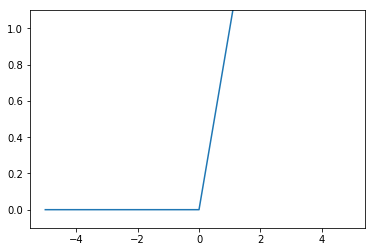

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 活性化関数

def plot_graph(x, y):
    plt.plot(x, y)
    plt.ylim(-0.1, 1.1)
    plt.show()

# -------------
# ステップ関数
# -------------
def step_function(x):
    if(x > 0):
        return 1
    else:
        return 0
    # ↑引数のxは実数のみ、ndarrayなどは渡せない

x1 = 0.1
x2 = np.array([1, -1])

print(step_function(x1))
# print(step_function(x2)) #-> Error

def step_function2(x):
    x2 = x > 0
    return x2.astype(np.int)

print(step_function2(x2))

x3 = np.arange(-5.0, 5.0, 0.1)
y = step_function2(x3)

# plot_graph(x3, y)


# -------------
# シグモイド関数
# -------------
def sigmoid_function(x):
    return 1 / (1 + np.exp(-x)) # exp(x)はネイピア数（e）のx乗

print(sigmoid_function(np.arange(-0.1, 1.0, 1)))
y = sigmoid_function(x3)

# plot_graph(x3, y)

# -------------
# ReLU関数
# -------------
def relu_function(x):
    return np.maximum(0, x)

y = relu_function(x3)
plot_graph(x3, y)
